In [91]:
import pandas as pd
import numpy as np
from scipy.special import digamma
import time
import math
import os

In [92]:
df1 = pd.read_csv('unique_userid_sample_1.csv')
df1.rename(columns = {'Rating': 'Count', 'UserID': 'UserId', 'MovieID':'ItemId'}, inplace = True)

In [93]:
df1

,UserId,ItemId,Count
0,2,110,5
1,2,151,3
2,2,260,5
3,2,376,3
4,2,539,3
...,...,...,...
1001232,71562,54001,4
1001233,71562,55269,4
1001234,71562,55820,4
1001235,71562,56782,4


Creating a validation set and making sure all of the users and items are also in the training set.

In [94]:
def create_validation_set(df, val_size=0.2):
    
    users = df['UserId'].unique()
    items = df['ItemId'].unique()

   
    mask = df.duplicated(subset=['UserId'], keep=False) & df.duplicated(subset=['ItemId'], keep=False)
    temp_df = df[mask]

    
    val_count = int(len(temp_df) * val_size)
    validation_set = temp_df.head(val_count)
    training_set = pd.concat([df, validation_set]).drop_duplicates(keep=False)

    
    validation_set = validation_set[validation_set['UserId'].isin(training_set['UserId'])]
    validation_set = validation_set[validation_set['ItemId'].isin(training_set['ItemId'])]

    
    training_set = pd.concat([training_set, validation_set]).drop_duplicates(keep=False)

    return training_set, validation_set



In [95]:
training_set, validation_set = create_validation_set(df1)

interaction_matrix = training_set.pivot_table(index='ItemId', columns='UserId', values='Count', fill_value=0)


values_users = [i for i in range(len(interaction_matrix))]
user_dict = {k:v for (k,v) in zip(interaction_matrix.columns, values_users)}
values_items = [i for i in range(len(interaction_matrix))]
item_dict = {k:v for (k,v) in zip(interaction_matrix.index, values_items)}

y_iu = interaction_matrix.values
y_ui = y_iu.transpose()

In [96]:
def initiliaze_parameters(num_users, num_items, k, a=0.3, a_prime=0.3, c=0.3, c_prime=0.3, b_prime=1.0, d_prime=1.0):
    
    k_shp = (a_prime + k * a) * np.ones(num_users)
    t_shp = (c_prime + k * c) * np.ones(num_items)
    k_rte = 1 * np.ones(num_users)
    t_rte = 1 * np.ones(num_items)
    
    
    gamma_rte = (a_prime + 0.01) * np.ones((num_users, k))
    gamma_shp = a * np.ones((num_users, k))
    lambda_rte = (c_prime + 0.01) * np.ones((num_items, k))
    lambda_shp = c * np.ones((num_items, k))
    
    phi = np.empty((num_users, num_items, k))
    
    return gamma_shp, gamma_rte, lambda_shp, lambda_rte, k_shp, k_rte, t_shp, t_rte, phi, a, a_prime, c, c_prime, b_prime, d_prime

Simple version of the CAVI algorithm

In [97]:
def CAVI_simple(num_users, num_items, k, y_ui, gamma_shp, gamma_rte, lambda_shp, lambda_rte, k_shp, k_rte, t_shp, t_rte, phi):
    

    # Now we will update phi_uik with both shape and rate parameters inside the loop
    for u in range(num_users):
        #print(u) if u %100 == 0 else None
        for i in range(num_items):
            if y_ui[u, i] > 0:
                l = np.zeros(5)
                for d in range(k):
                    exponent = (digamma(gamma_shp[u,d]) - np.log(gamma_rte[u,d]) +
                            digamma(lambda_shp[i,d]) - np.log(lambda_rte[i,d]))
                    l[d] = exponent

                #print(l / np.sum(l))
                #print(np.exp(l) / np.sum(np.exp(l)))
                #print(np.sum(l))
                # Exponentiate and normalize phi_uik so that it sums to 1 over k for each user/item pair
                phi[u, i, :] = np.exp(l) / np.sum(np.exp(l))
    
    print('Phi updated')
    
    ## Users (Theta) - Gamma Shape Update           
    for u in range(num_users):
        #print(u) if u %100 == 0 else None
        for d in range(k):
            k_sum = 0
            for i in range(num_items):
                k_sum += y_ui[u, i] * phi[u,i,d]
            gamma_shp[u,d] = a + k_sum
            #gamma_shpe[u, :] = a + (np.dot(y_ui[u, :], phi[u, :, :]))
            
    print('Users (Theta) - Gamma Shape Updated')
    
    ## Users (Theta) - Gamma Rate Update 
    for u in range(num_users):
        #print(u) if u %100 == 0 else None
        for d in range(k):
            k_sum = 0
            for i in range(num_items):
                k_sum += lambda_shp[i,d]/lambda_rte[i,d]
            gamma_rte[u,d] = k_shp[u] / k_rte[u] + k_sum
            
    print('Users (Theta) - Gamma Rate Updated')
    
    ## Users Activity - Gamma Rate Update 
    for u in range(num_users):
        #print(u) if u %100 == 0 else None
        k_sum = 0
        for d in range(k):
            k_sum += gamma_shp[u,d] / gamma_rte[u,d]
        k_rte[u] = a_prime / b_prime + k_sum
        
    print('Users Activity - Gamma Rate Updated')
    
    
    ## Items (Beta) - Gamma Shape Update  
    for i in range(num_items):
        #print(i) if i %100 == 0 else None
        for d in range(k):
            k_sum = 0
            for u in range(num_users):
                k_sum += y_ui[u, i] * phi[u,i,d]
            lambda_shp[i,d] = c + k_sum
            #gamma_shpe[u, :] = a + (np.dot(y_ui[u, :], phi[u, :, :]))
            
    print('Items (Beta) - Gamma Shape Updated')  
    
    ## Items (Beta) - Gamma Rate Update 
    for i in range(num_items):
        #print(i) if i %100 == 0 else None
        for d in range(k):
            k_sum = 0
            for u in range(num_users):
                k_sum += gamma_shp[u,d]/gamma_rte[u,d]
            lambda_rte[i,d] = t_shp[i] / t_rte[i] + k_sum
            
    print('Items (Beta) - Gamma Rate Updated')  

    ## Item Popularity - Gamma Rate Update 
    for i in range(num_items):
        #print(i) if i %100 == 0 else None
        k_sum = 0
        for d in range(k):
            k_sum += lambda_shp[i,d] / lambda_rte[i,d]
        t_rte[i] = c_prime / d_prime + k_sum
    
    print('Item Popularity - Gamma Rate Updated') 
    
    return gamma_shp, gamma_rte, lambda_shp, lambda_rte, k_shp, k_rte, t_shp, t_rte, phi

Optimized using numpy broadcasting

In [98]:
def CAVI(num_users, num_items, k, y_ui, gamma_shp, gamma_rte, lambda_shp, lambda_rte, k_shp, k_rte, t_shp, t_rte, phi):
    

    # Now we will update phi_uik with both shape and rate parameters inside the loop
    for u in range(num_users):
        #print(u) if u %100 == 0 else None
        for i in range(num_items):
            if y_ui[u, i] > 0:
                exponent = (digamma(gamma_shp[u,:]) - np.log(gamma_rte[u,:]) +
                            digamma(lambda_shp[i,:]) - np.log(lambda_rte[i,:]))
                    

                #print(l / np.sum(l))
                #print(np.exp(l) / np.sum(np.exp(l)))
                #print(np.sum(l))
                # Exponentiate and normalize phi_uik so that it sums to 1 over k for each user/item pair
                phi[u, i, :] = np.exp(exponent) / np.sum(np.exp(exponent))
    
    print('Phi updated')
    
    ## Users (Theta) - Gamma Shape Update           
    for u in range(num_users):
        #print(u) if u %100 == 0 else None
        for d in range(k):
            k_sum = y_ui[u, :] * phi[u,:,d]
            gamma_shp[u,d] = a + np.sum(k_sum)
            #gamma_shpe[u, :] = a + (np.dot(y_ui[u, :], phi[u, :, :]))
            
    print('Users (Theta) - Gamma Shape Updated')
    
    ## Users (Theta) - Gamma Rate Update 
    for u in range(num_users):
        #print(u) if u %100 == 0 else None
        for d in range(k):
            k_sum = lambda_shp[:,d]/lambda_rte[:,d]
            gamma_rte[u,d] = k_shp[u] / k_rte[u] + np.sum(k_sum)
            
    print('Users (Theta) - Gamma Rate Updated')
    
    ## Users Activity - Gamma Rate Update 
    for u in range(num_users):
        #print(u) if u %100 == 0 else None
        k_sum = 0
        for d in range(k):
            k_sum += gamma_shp[u,d] / gamma_rte[u,d]
        k_rte[u] = a_prime / b_prime + k_sum
        
    print('Users Activity - Gamma Rate Updated')
    
    
    ## Items (Beta) - Gamma Shape Update  
    for i in range(num_items):
        #print(i) if i %100 == 0 else None
        for d in range(k):
            k_sum = y_ui[:, i] * phi[:,i,d]
            lambda_shp[i,d] = c + np.sum(k_sum)
            #gamma_shpe[u, :] = a + (np.dot(y_ui[u, :], phi[u, :, :]))
            
    print('Items (Beta) - Gamma Shape Updated')  
    
    ## Items (Beta) - Gamma Rate Update 
    for i in range(num_items):
        #print(i) if i %100 == 0 else None
        for d in range(k):
            k_sum = gamma_shp[:,d]/gamma_rte[:,d]
            lambda_rte[i,d] = t_shp[i] / t_rte[i] + np.sum(k_sum)
            
    print('Items (Beta) - Gamma Rate Updated')  

    ## Item Popularity - Gamma Rate Update 
    for i in range(num_items):
        #print(i) if i %100 == 0 else None
        k_sum = 0
        for d in range(k):
            k_sum += lambda_shp[i,d] / lambda_rte[i,d]
        t_rte[i] = c_prime / d_prime + k_sum
    
    print('Item Popularity - Gamma Rate Updated') 
    
    return gamma_shp, gamma_rte, lambda_shp, lambda_rte, k_shp, k_rte, t_shp, t_rte, phi

In [99]:
def expectation(gamma_shp, gamma_rte, lambda_shp, lambda_rte, k, y_ui):
    
    num_users = y_ui.shape[0]
    num_items = y_ui.shape[1]
    
    ev_theta = np.empty((num_users,k))
    ev_beta = np.empty((num_items,k))
    for u in range(num_users):
        for d in range(k):
            ev_theta[u,d] = gamma_shp[u,d] / gamma_rte[u,d]

    for i in range(num_items):
        for d in range(k):
            ev_beta[i,d] = lambda_shp[i,d] / lambda_rte[i,d]
            
    return ev_theta, ev_beta
    
        

In [100]:
def log_likelihood(ev_theta, ev_beta, user_dict, item_dict, validation_set):
    likelihood_parameters = np.matmul(ev_theta, ev_beta.T)
    llk = 0
    for v in range(len(validation_set)):
        uu = validation_set['UserId'].iloc[v]
        ii = validation_set['ItemId'].iloc[v]
        u = user_dict[uu]
        i = item_dict[ii]
        value = validation_set['Count'].iloc[v]
        llk += - likelihood_parameters[u,i] - np.log(np.math.factorial(value)) + np.log(likelihood_parameters[u,i])*value
    return llk

In [114]:
i = 0
results = []
gamma_shp, gamma_rte, lambda_shp, lambda_rte, k_shp, k_rte, t_shp, t_rte, phi, a, a_prime, c, c_prime, b_prime, d_prime = initiliaze_parameters(y_ui.shape[0], y_ui.shape[1], k=5, a=0.3, a_prime=0.3, c=0.3, c_prime=0.3, b_prime=1.0, d_prime=1.0)
results.append(-np.inf)
results.append(-np.inf)
results.append(-np.inf)
results.append(-np.inf)
results.append(-np.inf)
while i < 500:
    print(f"Iteration {i}")
    start_time = time.time()
    
    
    gamma_shp, gamma_rte, lambda_shp, lambda_rte, k_shp, k_rte, t_shp, t_rte, phi = CAVI(y_ui.shape[0], y_ui.shape[1], 5, y_ui, gamma_shp, gamma_rte, lambda_shp, lambda_rte, k_shp, k_rte, t_shp, t_rte, phi)
    ev_theta, ev_beta = expectation(gamma_shp, gamma_rte, lambda_shp, lambda_rte, 5, y_ui)
    llk = log_likelihood(ev_theta, ev_beta, user_dict, item_dict, validation_set)
    print(llk)
    

    end_time = time.time()
    duration = end_time - start_time
    print(f"Iteration {i}: took {duration} seconds")
    
    results.append(llk)
    
    if results[-1] < results[-3] or ((results[-1] - results[-5])/ np.abs(results[-5])) < 0.000001:
        break
    i += 1
    

Iteration 0
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-194692.5226395934
Iteration 0: took 14.197275161743164 seconds
Iteration 1


/var/folders/7c/zq5pjc5156v6v5k591lqrbgc0000gp/T/ipykernel_23500/1984595820.py:26: RuntimeWarning: invalid value encountered in double_scalars
  if results[-1] < results[-3] or ((results[-1] - results[-5])/ np.abs(results[-5])) < 0.000001:


Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-193546.55774177454
Iteration 1: took 14.522169828414917 seconds
Iteration 2
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-193551.74147488622
Iteration 2: took 14.338734865188599 seconds
Iteration 3
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-193545.3874410749
Iteration 3: took 14.290282726287842 seconds
Iteration 4
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activi

Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-168094.0147515694
Iteration 28: took 14.413297891616821 seconds
Iteration 29
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-167787.68073309044
Iteration 29: took 14.839328050613403 seconds
Iteration 30
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-167501.9948955703
Iteration 30: took 14.680157899856567 seconds
Iteration 31
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamm

Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-163717.85279883834
Iteration 55: took 14.369180917739868 seconds
Iteration 56
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-163642.33788095225
Iteration 56: took 14.231961965560913 seconds
Iteration 57
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-163570.13654981533
Iteration 57: took 14.226110935211182 seconds
Iteration 58
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Ga

Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-162351.49021082174
Iteration 82: took 14.401237964630127 seconds
Iteration 83
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-162320.31332961452
Iteration 83: took 14.370859861373901 seconds
Iteration 84
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-162289.80925931895
Iteration 84: took 15.147313117980957 seconds
Iteration 85
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Ga

Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161854.18487495024
Iteration 109: took 14.401838064193726 seconds
Iteration 110
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161844.99543956097
Iteration 110: took 14.239023923873901 seconds
Iteration 111
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161836.4878879993
Iteration 111: took 14.299655199050903 seconds
Iteration 112
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta)

Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161625.01476440165
Iteration 136: took 16.264946937561035 seconds
Iteration 137
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161615.22990927612
Iteration 137: took 14.204609870910645 seconds
Iteration 138
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161606.0117709603
Iteration 138: took 14.225146055221558 seconds
Iteration 139
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated


Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161473.12446303456
Iteration 163: took 14.257019281387329 seconds
Iteration 164
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161469.11323168044
Iteration 164: took 13.786067008972168 seconds
Iteration 165
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161465.2556470953
Iteration 165: took 13.968991041183472 seconds
Iteration 166
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated


Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161363.90646237347
Iteration 190: took 14.8712158203125 seconds
Iteration 191
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161359.0323288323
Iteration 191: took 13.96406602859497 seconds
Iteration 192
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161354.07789515457
Iteration 192: took 13.81663703918457 seconds
Iteration 193
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
User

Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161272.18628287743
Iteration 217: took 13.856382846832275 seconds
Iteration 218
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161269.90744603833
Iteration 218: took 13.873632192611694 seconds
Iteration 219
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161267.60059683025
Iteration 219: took 13.788598775863647 seconds
Iteration 220
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated

Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161231.16695600018
Iteration 244: took 13.504181146621704 seconds
Iteration 245
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161229.39567689542
Iteration 245: took 13.591403007507324 seconds
Iteration 246
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161227.55463746854
Iteration 246: took 13.78006887435913 seconds
Iteration 247
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated


Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161175.54724071606
Iteration 271: took 1064.7264680862427 seconds
Iteration 272
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161173.11431924545
Iteration 272: took 13.942115068435669 seconds
Iteration 273
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161170.6624761954
Iteration 273: took 14.540718078613281 seconds
Iteration 274
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated


Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161133.8892605307
Iteration 298: took 13.701306104660034 seconds
Iteration 299
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161132.71543656068
Iteration 299: took 13.791271209716797 seconds
Iteration 300
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161131.51853560898
Iteration 300: took 13.64104413986206 seconds
Iteration 301
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
U

Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161098.7900873492
Iteration 325: took 13.653456211090088 seconds
Iteration 326
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161097.49483199054
Iteration 326: took 13.530463933944702 seconds
Iteration 327
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161096.16471246348
Iteration 327: took 13.56837773323059 seconds
Iteration 328
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
U

Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161061.46028155438
Iteration 352: took 13.581035137176514 seconds
Iteration 353
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161060.29777735283
Iteration 353: took 13.556556940078735 seconds
Iteration 354
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161059.15622578666
Iteration 354: took 13.578054189682007 seconds
Iteration 355
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated

Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161036.924604332
Iteration 379: took 13.541655778884888 seconds
Iteration 380
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161036.01663985717
Iteration 380: took 13.418297052383423 seconds
Iteration 381
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161035.09805356743
Iteration 381: took 13.536794900894165 seconds
Iteration 382
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
U

Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161003.79667540482
Iteration 406: took 928.8229529857635 seconds
Iteration 407
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161002.2893242252
Iteration 407: took 13.71076488494873 seconds
Iteration 408
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-161000.6928394594
Iteration 408: took 13.498831033706665 seconds
Iteration 409
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Use

Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-160970.71528491154
Iteration 433: took 13.780776023864746 seconds
Iteration 434
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-160969.99563389577
Iteration 434: took 541.0915420055389 seconds
Iteration 435
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-160969.24411995595
Iteration 435: took 13.697335958480835 seconds
Iteration 436
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated


Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-160947.64329206478
Iteration 460: took 13.848414182662964 seconds
Iteration 461
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-160947.2182343925
Iteration 461: took 23.020528078079224 seconds
Iteration 462
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-160946.77572002047
Iteration 462: took 13.687724113464355 seconds
Iteration 463
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated


Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-160922.92315533964
Iteration 487: took 13.678478002548218 seconds
Iteration 488
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-160922.09572022752
Iteration 488: took 13.50608515739441 seconds
Iteration 489
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
Users Activity - Gamma Rate Updated
Items (Beta) - Gamma Shape Updated
Items (Beta) - Gamma Rate Updated
Item Popularity - Gamma Rate Updated
-160921.3014501832
Iteration 489: took 13.586792945861816 seconds
Iteration 490
Phi updated
Users (Theta) - Gamma Shape Updated
Users (Theta) - Gamma Rate Updated
U

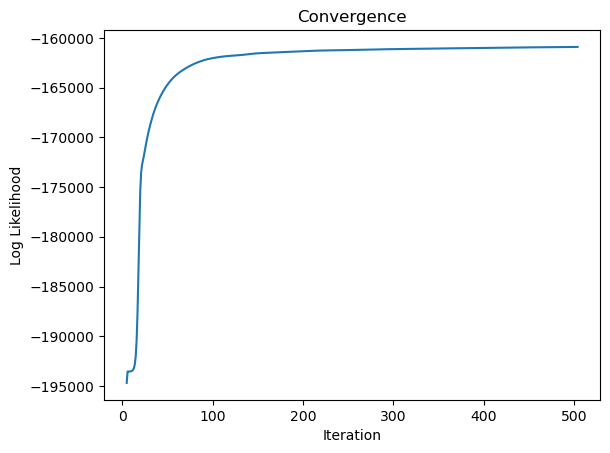

In [115]:
import matplotlib.pyplot as plt


plt.plot(results)  

plt.title('Convergence')
plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')


plt.show()

In [116]:
np.save('gamma_shp.npy', gamma_shp)  
np.save('gamma_rte.npy', gamma_rte)  
np.save('lambda_shp.npy', lambda_shp)  
np.save('lambda_rte.npy', lambda_rte)  
np.save('k_shp.npy', k_shp)  
np.save('k_rte.npy', k_rte)  
np.save('t_shp.npy', t_shp)  
np.save('t_rte.npy', t_rte)  
np.save('phi.npy', phi)  


In [117]:
import numpy as np

gamma_shp = np.load('gamma_shp.npy')
gamma_rte = np.load('gamma_rte.npy')
lambda_shp = np.load('lambda_shp.npy')
lambda_rte = np.load('lambda_rte.npy')
k_shp = np.load('k_shp.npy')
k_rte = np.load('k_rte.npy')
t_shp = np.load('t_shp.npy')
t_rte = np.load('t_rte.npy')
phi = np.load('phi.npy')


In [118]:
validation_set

,UserId,ItemId,Count
2613,182,1,4
2614,182,2,3
2615,182,3,3
2616,182,4,4
2617,182,5,4
...,...,...,...
200227,14539,1784,5
200228,14539,1895,3
200229,14539,1923,5
200230,14539,1942,4


In [119]:
predictions = validation_set.copy()

In [120]:
predictions['Pred'] = 0

For predictions expectations of thetas and betas are taken since we have a gamma prior over them. Later these expectations are used in the dot product.

In [121]:
for i in range(len(predictions)):
    userid = predictions['UserId'].iloc[i] 
    itemid = predictions['ItemId'].iloc[i]
    user = user_dict[userid]
    item = item_dict[itemid]
    expv_theta = gamma_shp[user,:] / gamma_rte[user,:]
    expv_beta = lambda_shp[item,:] / lambda_rte[item,:]
    predictions['Pred'].iloc[i] = np.dot(expv_theta, expv_beta)

            
    

In [122]:
predictions

,UserId,ItemId,Count,Pred
2613,182,1,4,6.359411
2614,182,2,3,3.320543
2615,182,3,3,2.389684
2616,182,4,4,0.546297
2617,182,5,4,2.232174
...,...,...,...,...
200227,14539,1784,5,0.993001
200228,14539,1895,3,0.114029
200229,14539,1923,5,1.006701
200230,14539,1942,4,0.051531


In [123]:
predictions['SE'] = (predictions['Count'] - predictions['Pred'])

In [124]:
predictions['SE'].sum() / 36939

1.7006625024173276